## LINK TO LOGISTIC REGRESSION NEWTON'S METHOD ON GITHUB:
https://github.com/lucasf46/lucasf46.github.io/blob/main/posts/BlogPost5/NewtonOptimizer.py

# INTRODUCTION

This blog post implements the Newton Optimizer for Logistic Regression. The Newton Optimizer is a second-order optimization technique that uses the Hessian matrix to find the optimal weights for the logistic regression model. After implementing Logistic Regression with the Newton Optimizer, we will conduct three experiments to demonstrate the advantages and disadvantages of the method in determining the optimal weight vector, by manipulating the alpha value. In conclusion, this post will look at the computational costs of Newton's method compared to gradient descent. 

In [386]:
%load_ext autoreload
%autoreload 2
from NewtonOptimizer import LogisticRegression, GradientDescentOptimizer, NewtonOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [387]:
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

Let's start by borrowing code from the Logistic Regression blog post that generates some linearly separable data for our Newton Optimizer to work with.

In [388]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(n_points = 500, noise = 0.5, p_dims = 2)

In [389]:
def plot_classification_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , "^"]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

In [390]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

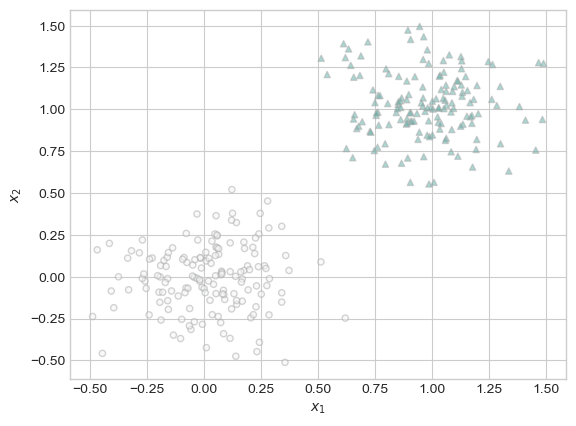

In [391]:
fig, ax = plt.subplots(1, 1)
X, y = classification_data()
plot_classification_data(X, y, ax)

Just confirming that our data appears to be linearly separable before feeding it to our Logistic Regression model with Newton's Method. 

# EXPERIMENT 1

Now that we have some linearly separable data to work with, our first experiment involves choosing an alpha value such that Newton's Method properly converges to the correct weight vector w. 

First, we initialize our model:

In [392]:
LR = LogisticRegression() 
opt = NewtonOptimizer(LR)

We are using an alpha value of 0.25 in this first experiment. 

In [393]:
loss_vec = []
for _ in range(6000):
    loss = opt.step(X, y, alpha = 0.25)
    loss_vec.append(loss)

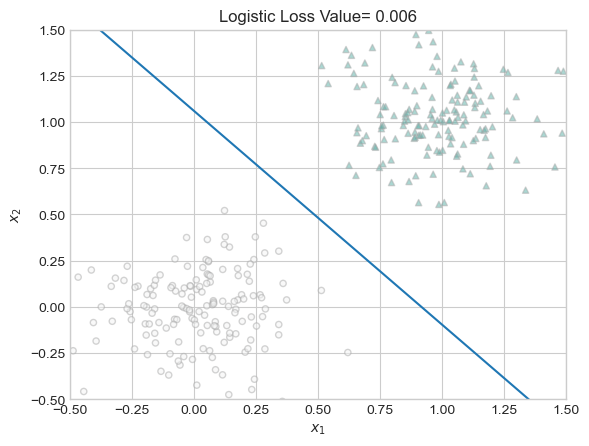

In [394]:
fig, ax = plt.subplots(1, 1)
opt_loss = loss_vec[len(loss_vec) - 1]
ax.grid(True)
ax.set_title(f"Logistic Loss Value= {opt_loss:.3f}")
ax.set(xlim = (-0.5, 1.5), ylim = (-0.5, 1.5))

plot_classification_data(X, y, ax)
draw_line(torch.clone(LR.w), -2, 2, ax)

After 6000 iterations, and an alpha value of 0.25, we see that the model seems to be working. The loss value converges to a value nearly 0 and visually, the decision boundary splits the two clusters of data nicely. 

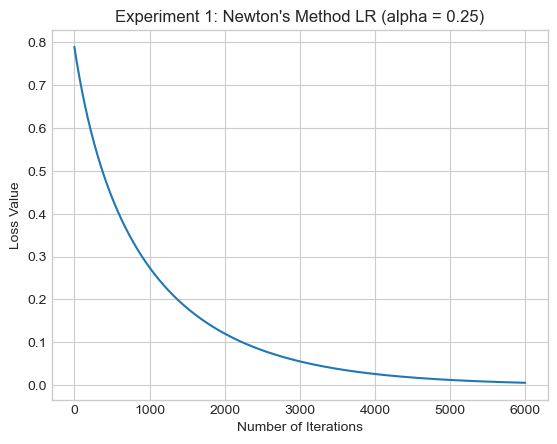

In [395]:
plt.plot(loss_vec)
labs = plt.gca().set(xlabel = "Number of Iterations", ylabel = "Loss Value", title = "Experiment 1: Newton's Method LR (alpha = 0.25)")

We are confident that an alpha value of 0.25 is an appropriate choice because the model converges to a loss of 0 and the optimal weight vector.

# EXPERIMENT 2

We now look to find the circumstances under which Logistic Regression with Newton's Method converges noticeably faster than standard gradient descent, in the sense of decreasing empirical risk. 

First, we initialize two Logistic Regression models, one with Newton's Method and the other with standard gradient descent. 

In [396]:
Newton_LR = LogisticRegression()
Standard_LR = LogisticRegression()

Newton_Opt = NewtonOptimizer(Newton_LR)
Standard_Opt = GradientDescentOptimizer(Standard_LR)

In [397]:
Standard_lossVec = []
for _ in range(6000):
    Standard_loss = Standard_Opt.step(X, y, alpha = 0.01, beta = 0)
    Standard_lossVec.append(Standard_loss)

Newton_lossVec = []
for _ in range(6000):
    Newton_loss = Newton_Opt.step(X, y, alpha = 0.5)
    Newton_lossVec.append(Newton_loss)

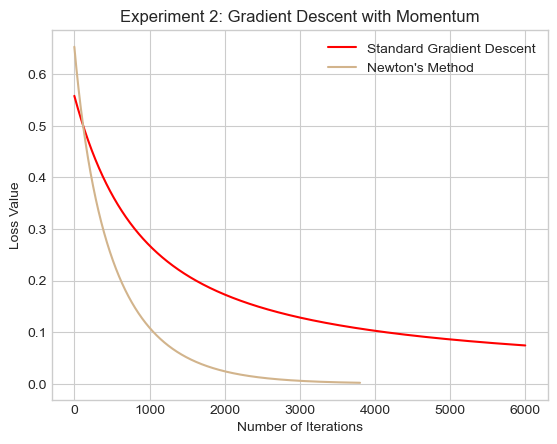

In [398]:
plt.plot(Standard_lossVec, color = "red", label = "Standard Gradient Descent")
plt.plot(Newton_lossVec, color = "tan", label = "Newton's Method")
plt.legend()
labs = plt.gca().set(xlabel = "Number of Iterations", ylabel = "Loss Value", title = "Experiment 2: Gradient Descent with Momentum")

Under these circumstances, where the Newton's Method alpha is 0.5 and the Standard Gradient Descent's alpha is 0.01, we can see that Newton's Method converges to a loss of 0 and the value of an optimal weight vector much more quickly than Standard Gradient Descent. The alpha of Newton's Method must be large enough in comparison to the alpha of Standard Gradient Descent for Newton's Method to be the optimal model in terms of convergence. 

# EXPERIMENT 3

We now explore a scenario where if the alpha value is too large, the Logistic Regression model with Newton's Method, will not converge to a loss of 0 and produce an optimal weight vector. 

In [399]:
Newton_LR = LogisticRegression() 
Newton_Opt = NewtonOptimizer(Newton_LR)

In [400]:
X, y = classification_data(n_points=300, noise = 0.5)

In [401]:
Newton_lossvec = []
for _ in range(400):
    Newton_loss = Newton_Opt.step(X, y, alpha = 500)
    Newton_lossvec.append(Newton_loss)

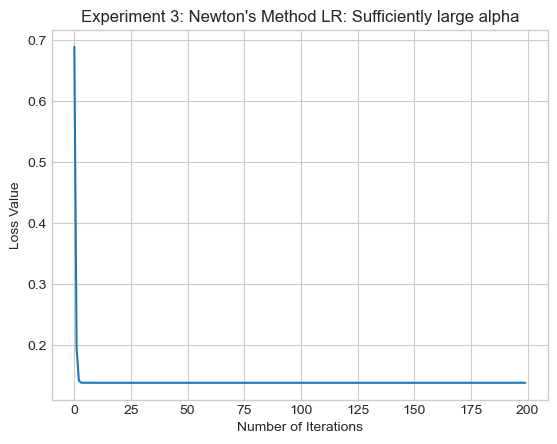

In [402]:
plt.plot(Newton_lossvec)
labs = plt.gca().set(xlabel = "Number of Iterations", ylabel = "Loss Value", title = "Experiment 3: Newton's Method LR: Sufficiently large alpha")

As we can see, with a sufficiently large alpha value, the loss value remains constant at a value above zero, thereby not converging. 

# OPERATION COUNTING

We need to describe the total computational cost of Newton's Method as compared to Gradient Descent.

First, lets note our assumptions:

Let c = computational unit
Assumptions: 
- c to compute the loss L
- 2c to compute the gradient ∇L
- pc units to compute the Hessian
- $k_1 p^\gamma$ units to invert a p x p matrix
- $k_2 p^2$ units to perform matrix-vector multiplication required by Newton's Method
- Newton's Method converges to adequate solution in $t_{nm}$ steps
- Gradient Descent converges to adequate solution in $t_{gd}$ steps

## Newton's Method Computation Calculation

Single step:
- 2c + pc + $k_1 p^\gamma$ + $k_2 p^2$

Sum:
- c + $t_{nm}$ * (2c + pc + $k_1 p^\gamma$ + $k_2 p^2$)

## Gradient Descent's Computation Calculation

Single step:
- c

Sum:
- c + $t_{gd}$ * 2c

We can now set up an inequality to determine when $t_{nm}$ is less computationally expensive than $t_{gd}$:

c + $t_{gd}$ * 2c > c + $t_{nm}$ * (2c + pc + $k_1 p^\gamma$ + $k_2 p^2$)

Simplify:

$t_{gd}$ * 2c > $t_{nm}$ * (2c + pc + $k_1 p^\gamma$ + $k_2 p^2$)

$t_{gd}$ > $t_{nm}$ / 2c * (2c /2c + pc / 2c + $k_1 p^\gamma$ /2c + $k_2 p^2$ / 2c)

$t_{gd}$ > $t_{nm}$ / 2c * (1 + p/2 + $k_1 p^\gamma$ / 2c + $k_2 p^2$ / 2c)


The simplified inequality indicates that the value of $t_{nm}$ has to be smaller than $t_{gd}$ by a factor of ($t_{nm}$ / 2c * (1 + p/2 + $k_1 p^\gamma$ / 2c + $k_2 p^2$ / 2c))

In this expression, the dominant terms are $k_1 p^\gamma$ and $k_2 p^2$. If the value of p is large, these values will grow exponentially, making Gradient Descent a more cost-effective approach than Newton's Method.

# DISCUSSION

In this blog post, I implemented Newton's Method with Logistic Regression and experimented with the behavior of the algorithm given a particular alpha value. In the first experiment, we saw that Netwon's Method converges with a small enough alpha. In the second experiment, we saw that as long as Newton's Method had a large enough alpha compared to the alpha of standard gradient descent, Newton's Method converges quicker than the standard gradient descent. Our last experiment showed how Newton's Method will not converge if the alpha value is too large. In conclusion, we calculated the cost of computation for Netwton's Method to highlight that in general, apart from certain conditions, Netwon's Method is more computationally expensive than standard gradient descent.